In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from rlxutils import subplots, copy_func
from progressbar import progressbar as pbar
%matplotlib inline

In [14]:
def get_posterior(likelihood_fn, prior_fn, support, atol=1e-5):
    assert len(support)==2

    Z = quad(lambda x: likelihood_fn(x)*prior_fn(x), *support)
    if Z[1]>atol:
        raise ValueError(f"numerical integration did not converge {Z[1]}")
    
    posterior_fn = lambda x: copy_func(likelihood_fn)(x) * copy_func(prior_fn)(x) /  Z[0]
    return posterior_fn

# the posterior of one measurement

In [4]:
support = [-20,20]

likelihood = lambda x: stats.norm(loc=2,scale=.5).pdf(x)
prior      = lambda x: stats.norm(loc=4,scale=1).pdf(x)
posterior  = get_posterior(likelihood, prior, support)

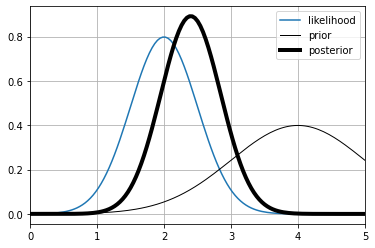

In [8]:
xr = np.linspace(*support,1000)
plt.plot(xr, likelihood(xr), label="likelihood")
plt.plot(xr, prior(xr), label="prior", color="black", lw=1)
plt.plot(xr, posterior(xr), label="posterior", color="black", lw=4)
plt.grid();
plt.legend();
plt.xlim(0,5);

In [26]:
a = ValueError("hoahoa")
str(a)


'hoahoa'

# several measurements

we repeat the steps above, using the posterior obtained at each step as the prior for next measurement

In [38]:
def estimate_position(
    z_real = 23,
    prior_mean = 20,
    prior_std = 10,
    sensor_sigma = .7,
    support = [-10, 50]
):
    
    initial_prior      = eval(f"lambda x: stats.norm(loc={prior_mean},scale={prior_std}).pdf(x)")
    measurements = np.random.normal(loc=z_real, scale=sensor_sigma, size=10)
    posteriors = []
    
    measurements = np.array([22.8703975 , 21.20978814, 23.02236771, 23.11080595, 22.57912349,
           23.21069837, 22.7183124 , 22.04716496, 23.77469721, 22.520084  ])
    
    
    prior = initial_prior
    for i in pbar(range(len(measurements))):
        # compute the likelihood
        likelihood = eval(f"lambda x: stats.norm(loc={measurements[i]},scale={sensor_sigma}).pdf(x)")
        
        # compute the posterior, stop if integration errors
        try:
            posterior = get_posterior(likelihood, prior, support)
            posteriors.append(posterior)
        except ValueError as e:
            print (e)
            print (f"stopped at measurement {i} = {measurements[i]}")
            break

        # the posterior becomes the next prior 
        prior = posteriors[-1]
        
    # plot stuff
    xr = np.linspace(*support, 1000)
    for ax,i in subplots(len(posteriors)+1, n_cols=6):
        if i==0:
            plt.plot(xr, initial_prior(xr), color="steelblue")
            plt.title("prior")
            plt.ylim(0,0.5)
            plt.xlim(z_real-5, z_real+5)
        else:
            plt.plot(xr, posteriors[i-1](xr), color="steelblue")
            plt.title(f"measurement {i}")
            plt.axvline(measurements[i-1], color="black", ls="--")
            plt.xlim(z_real-2, z_real+2)

        plt.grid();
        plt.axvline(z_real, color="black")
    plt.tight_layout()

## a very uninformative prior 

observe how, as measurements are processed, the posterior becomes narrower (less uncertainty) and approaches the real value

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

lambda x: stats.norm(loc=5,scale=20).pdf(x)


100% (10 of 10) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


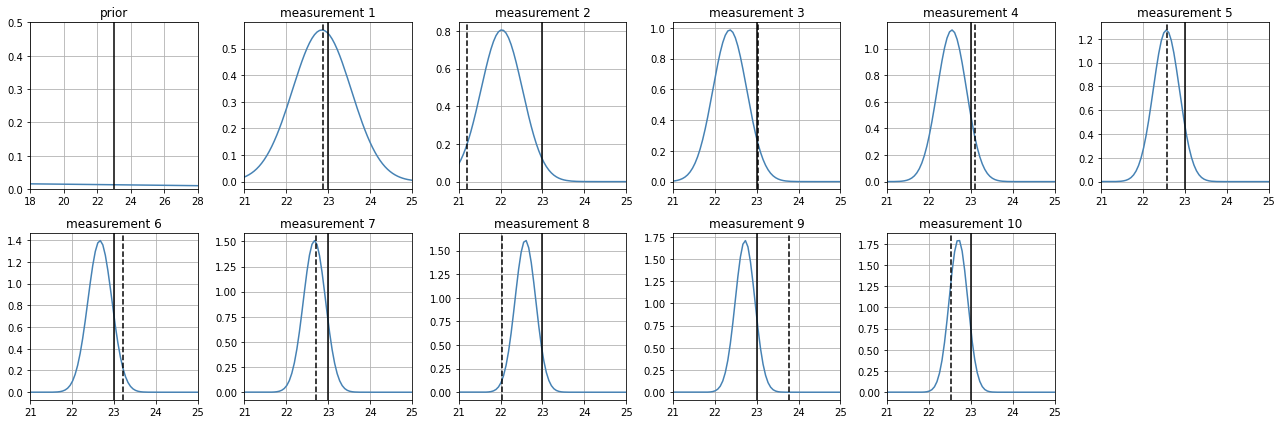

In [37]:
estimate_position(
    z_real = 23,
    prior_mean = 5,
    prior_std = 20,
    sensor_sigma = .7
)

## a more accurate sensor converges faster and with less ucertainty

however observe that numerical integration might stop us from processing further measurements

 10% (1 of 10) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02

lambda x: stats.norm(loc=20,scale=10).pdf(x)


 60% (6 of 10) |###############          | Elapsed Time: 0:00:02 ETA:   0:00:02

numerical integration did not converge 4572.079038493393
stopped at measurement 6 = 22.7183124


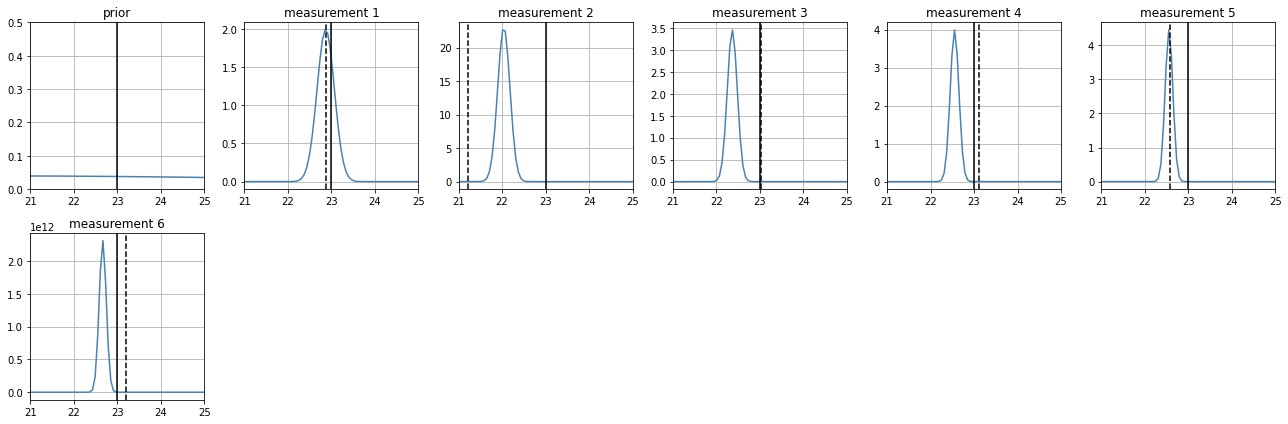

In [34]:

estimate_position(
    z_real = 23,
    prior_mean = 20,
    prior_std = 10,
    sensor_sigma = .2
)

## but if we are very wrong and very confident on our prior, we pay for it

Wrong mean with a very narrow stdev. It takes many measurements to converge to the real value.

Recall, narrow stdevs anywhere always represent small uncertainty

 90% (9 of 10) |######################   | Elapsed Time: 0:00:06 ETA:   0:00:01

numerical integration did not converge 14.156454653985861
stopped at measurement 9 = 22.520084


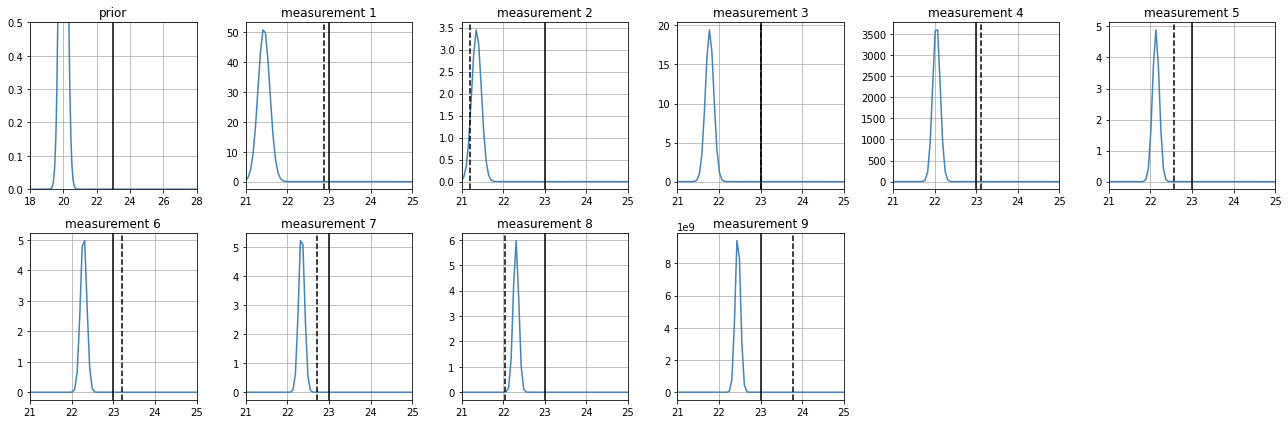

In [39]:
estimate_position(
    z_real = 23,
    prior_mean = 20,
    prior_std = .2,
    sensor_sigma = .2
)